# Exploring the Animal Kingdom dataset for action recognition

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

## Importing metadata about Action Recognition (AR) dataset

In [2]:
AR_data = pd.read_excel('AR_metadata.xlsx', sheet_name='AR')

AR_data.head()

,S/N,video_id,type,labels,list_animal_action
0,1,AAACXZTV,train,"2,40","[('Common Crane', 'Attending'), ('Common Crane..."
1,2,AABCQPTK,train,"2,15","[('Singing Nightingale', 'Attending'), ('Singi..."
2,3,AABKMGHE,train,78,"[('Snake', 'Moving')]"
3,4,AACJGIQR,train,"102,1,39,8,120,97","[('Mongoose', 'Biting'), ('Black Mamba', 'Sens..."
4,5,AACKOHGA,train,"2,68,133,116","[('Meerkat', 'Walking'), ('Meerkat', 'Attendin..."


In [3]:
animal_data = pd.read_excel('AR_metadata.xlsx', sheet_name='Animal')

animal_data.head()

,Animal,Parent Class,Class,Sub-Class,Young,Generic name
0,Abalone,Sea animal,Sea animal / Shellfish,Shellfish / Abalone / Clam / Mussel / Scallop,NaN,NaN
1,Acyrthosiphon pisum Aphid,Insect,Insect,Ant / Termite / Aphid,NaN,NaN
2,Aedes aegypti Mosquito,Insect,Insect,Mosquito / Crane fly,NaN,NaN
3,Aedes aegypti Mosquito Larva,Insect,Insect / Larva / Pupa,Larva / Pupa,Yes,NaN
4,Aesculapian Snake,Reptile,Reptile / Snake,Snake / Cobra / Viper / Python,NaN,NaN


In [4]:
fish = list(animal_data[animal_data['Class'] == 'Fish']['Animal'])

In [5]:
print('Number of fish species in dataset:', len(fish))
print('Examples:', fish[:3])

Number of fish species in dataset: 59
Examples: ['Archer Fish', 'Atlantic Blue Tang Fish', 'Barracuda Fish']


In [6]:
action_dict = {AR_data['video_id'][i] : eval(AR_data['list_animal_action'][i]) \
               for i in AR_data.index}

for id, actions in list(action_dict.items())[:3]:
    print(id, actions)

AAACXZTV [('Common Crane', 'Attending'), ('Common Crane', 'Eating')]
AABCQPTK [('Singing Nightingale', 'Attending'), ('Singing Nightingale', 'Chirping')]
AABKMGHE [('Snake', 'Moving')]


## Frame-by-frame action recognition

In [9]:
frame_AR = pd.read_csv('val.csv', sep=' ')

frame_AR.head()

,original_vido_id,video_id,frame_id,path,labels,type
0,AAAUILHH,46,1,AAAUILHH/AAAUILHH_t000001.jpg,16,test
1,AAAUILHH,46,2,AAAUILHH/AAAUILHH_t000002.jpg,16,test
2,AAAUILHH,46,3,AAAUILHH/AAAUILHH_t000003.jpg,16,test
3,AAAUILHH,46,4,AAAUILHH/AAAUILHH_t000004.jpg,16,test
4,AAAUILHH,46,5,AAAUILHH/AAAUILHH_t000005.jpg,16,test


In [20]:
frames_dict = {frame_AR['original_vido_id'][i] : [] for i in frame_AR.index}

In [21]:
action_frames_dict = {id : {} for id in frames_dict}

In [22]:
for id, frame_list in frames_dict.items():
    relevant_data = frame_AR[frame_AR['original_vido_id'] == id]

    for i in relevant_data.index:
        frame = relevant_data['frame_id'][i]

        if frame not in frame_list:
            frame_list.append(frame)

        labels = relevant_data['labels'][i]

        for label in labels.split(','):
            if label not in action_frames_dict[id]:
                action_frames_dict[id][label] = [frame]

            else:
                action_frames_dict[id][label].append(frame)

frames_length_dict = {id : len(frame_list) for id, frame_list in frames_dict.items()}

In [23]:
print('Videos with missing frames in the frame-by-frame dataset:')

any_missing = False

for id, length in frames_length_dict.items():
    if length != frames_dict[id][-1]:
        print(id)

        any_missing = True

if not any_missing:
    print('None')


Videos with missing frames in the frame-by-frame dataset:
None


In [48]:
action_lengths_dict = {}
action_proportions_dict = {}

for id, action_dict in action_frames_dict.items():
    video_length = frames_length_dict[id]
    
    for action, frames in action_dict.items():
        if action not in action_lengths_dict:
            action_lengths_dict[action] = []

        if action not in action_proportions_dict:
            action_proportions_dict[action] = []

        length_list = []
        proportions_list = []
        current_length = 1

        for i in range(1, len(frames)):
            if frames[i] == frames[i - 1] + 1:
                current_length += 1
            else:
                length_list.append(current_length)
                proportions_list.append(current_length / video_length)
                current_length = 1

        length_list.append(current_length)    
        proportions_list.append(current_length / video_length)    
    
        action_lengths_dict[action].extend(length_list)
        action_proportions_dict[action].extend(proportions_list)

In [36]:
# Checking for bugs.

test_action = list(action_lengths_dict.keys())[0]

print(f'Calculated number of frames with action {test_action}: {sum(action_lengths_dict[test_action])}')

counter = 0

for i in frame_AR.index:
    if test_action in frame_AR['labels'][i].split(','):
        counter += 1

print(f'Actual number of frames with action {test_action}: {counter}')

Calculated number of frames with action 16: 4134
Actual number of frames with action 16: 4134


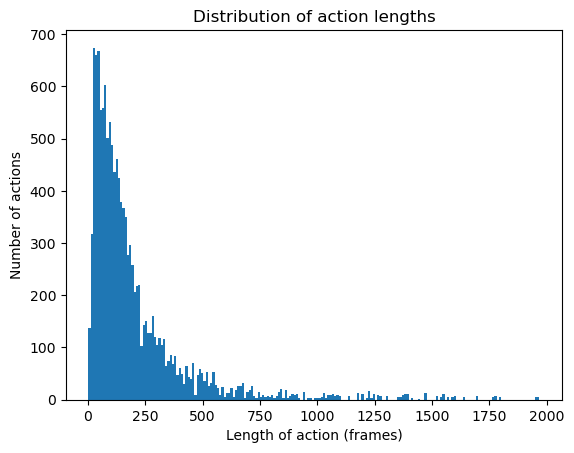

In [46]:
all_lengths = [length for length_list in action_lengths_dict.values() for length in length_list]

plt.hist(all_lengths, bins=200)

plt.xlabel('Length of action (frames)')
plt.ylabel('Number of actions')
plt.title('Distribution of action lengths')

plt.show()

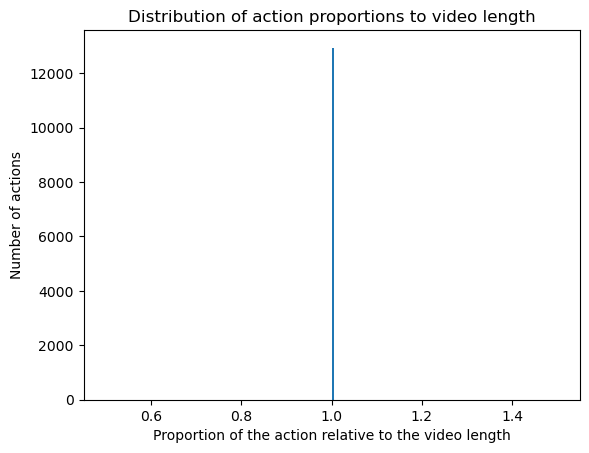

In [49]:
all_proportions = [proportion for proportion_list in action_proportions_dict.values() for proportion in proportion_list]

plt.hist(all_proportions, bins=200)

plt.xlabel('Proportion of the action relative to the video length')
plt.ylabel('Number of actions')
plt.title('Distribution of action proportions to video length')

plt.show()

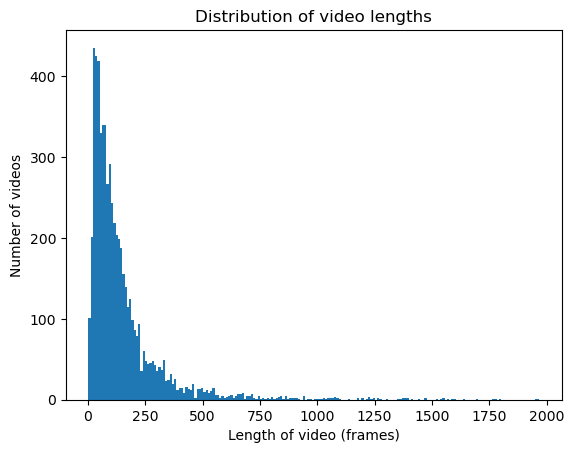

In [47]:
all_lengths = [length for length in frames_length_dict.values()]

plt.hist(all_lengths, bins=200)

plt.xlabel('Length of video (frames)')
plt.ylabel('Number of videos')
plt.title('Distribution of video lengths')

plt.show()

## Finding videos with relevant species

In [7]:
fish_videos = []

for id, actions in action_dict.items():
    for item in actions:
        animal = item[0]

        if animal in fish and id not in fish_videos:
            fish_videos.append(id)

In [8]:
print('Number of fish videos in dataset:', len(fish_videos))

Number of fish videos in dataset: 887


## Finding videos with relevant actions
In our case, these are actions related to predation, namely:

* 1: **Attacking**
* 7: **Being eaten**
* 14: **Chasing**
* 47: **Fighting**
* 8: **Biting**
* 51: **Fleeing**
* 96: **Retaliating**
* 120: **Struggling**

In [47]:
relevant_actions = ['Attacking', 'Chasing', 'Fighting', 'Biting', \
                    'Being eaten', 'Fleeing', 'Retaliating', 'Struggling']

In [58]:
action_data = pd.read_excel('AR_metadata.xlsx', sheet_name='Action')

for i in action_data[action_data['Action'].isin(relevant_actions)].index:
    print('--' + action_data['Action'][i])
    print(action_data['Description'][i])
    print()

--Attacking
Animal rushes and leaps on another another with bites, pecks or kicks

--Chasing
Animal "runs" after the fleeing animal, however no biting occurs

--Fighting
Include wrestling

--Fleeing
Different from escaping, animal 'runs' away from its predator or danger, often with rapid change of direction but without having been caught first

--Retaliating
Animal makes a defending attack (i.e., "attacks" its attacker back). Include ramming by goats

--Struggling
Animal struggles from the clutch, grip, or bite by its predator

--Biting
Animal sinks its teeth into the object or animal, but does not eat / feed / chew on the object or food

--Being eaten
nan



In [48]:
fish_action_dict = {id : actions for id, actions in action_dict.items() \
                    if id in fish_videos}

Please note that during the selection of relevant videos, only clips in which fish are the performers of attack-related actions (either on the predator or prey side) are selected. However, the clip might contain animals other than fish, and they might be involved in the attack as well (e.g., snake eating fish).

In [71]:
relevant_videos = []

# Counting the distribution of relevant action types.
action_counter = {action : 0 for action in relevant_actions}

# Counting the distribution of species in relevant actions.
species_counter = {}

for id, actions in fish_action_dict.items():
    for item in actions:
        animal, action = item

        if animal in fish and action in relevant_actions:
            action_counter[action] += 1

            if animal in species_counter:
                species_counter[animal] += 1

            else:
                species_counter[animal] = 1
            
            if id not in relevant_videos:
                relevant_videos.append(id)

In [64]:
print('Number of relevant videos in dataset:', len(relevant_videos))

Number of relevant videos in dataset: 81


In [51]:
relevant_AR_data = AR_data[AR_data['video_id'].isin(relevant_videos)]

In [52]:
relevant_AR_data.head()

,S/N,video_id,type,labels,list_animal_action
123,124,ADBJMPIF,train,"40,51,123","[('Sardine', 'Fleeing'), ('Sea Lion', 'Eating'..."
492,493,ANDAXPAB,train,"49,45,53,8,120,133","[('Dice Snake', 'Exploring'), ('Dice Snake', '..."
506,507,ANOGFCND,train,"1,51","[('Fish', 'Fleeing'), ('Snake', 'Attacking')]"
1347,1348,BKSKLMHZ,train,"120,8","[('Natrix Tessellata Snake', 'Biting'), ('Fish..."
2185,2186,CITPDPIF,train,"1,123,51","[('Sardine', 'Fleeing'), ('Sardine', 'Swimming..."


In [53]:
print('Number of relevant training samples:', len(relevant_AR_data[relevant_AR_data['type'] == 'train']))
print('Number of relevant test samples:', len(relevant_AR_data[relevant_AR_data['type'] == 'test']))

Number of relevant training samples: 74
Number of relevant test samples: 7


## Inspecting relevant clips

### Distribution of relevant actions

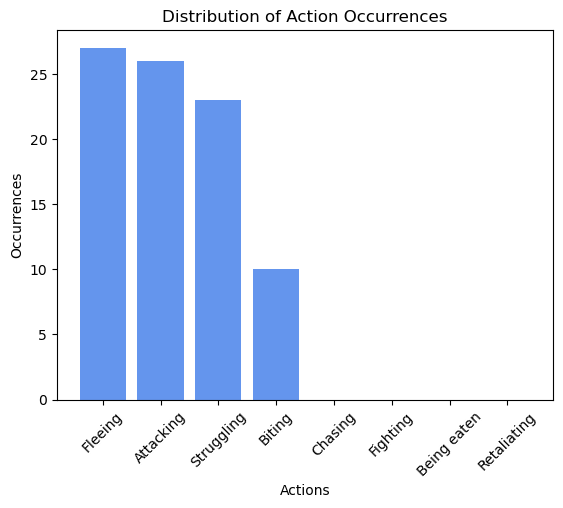

In [82]:
sorted_items = sorted(action_counter.items(), key=lambda x: x[1], reverse=True)

actions, occurrences = zip(*sorted_items)

plt.bar(actions, occurrences, color='cornflowerblue')
plt.xlabel('Actions')
plt.ylabel('Occurrences')
plt.title('Distribution of Action Occurrences')
plt.xticks(rotation=45)
plt.show()

### Distribution of different fish species in relevant actions

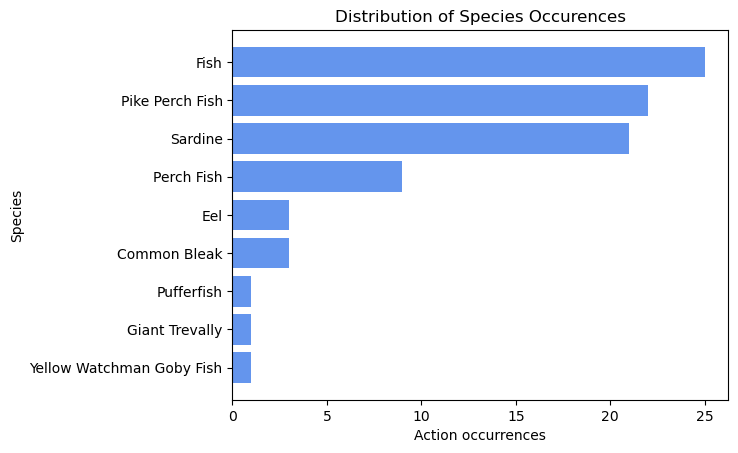

In [80]:
sorted_items = sorted(species_counter.items(), key=lambda x: x[1], reverse=False)

species, occurrences = zip(*sorted_items)

plt.barh(species, \
        occurrences, \
            color='cornflowerblue')
plt.ylabel('Species')
plt.xlabel('Action occurrences')
plt.title('Distribution of Species Occurences')
plt.show()